# SocialGraph-GCN: Link Prediction on Social Graphs

This notebook implements an end-to-end **link prediction** pipeline in Colab with reproducible training, baseline comparison, and interactive inference.

Main goals:
- download a real social network dataset directly (no manual upload)
- train a small 2-layer GCN
- compare against a structural baseline (Common Neighbors)
- build a friend recommendation demo with Gradio


## 1) Environment and Reproducibility Setup

In [ ]:
# Install dependencies in Colab runtime
!pip -q install networkx gradio matplotlib pandas numpy scikit-learn
!pip -q install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.3 MB/s eta 0:00:00


In [ ]:
import gzip
import random
import shutil
import urllib.request
from pathlib import Path

import gradio as gr
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.metrics import average_precision_score, roc_auc_score
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cuda


## 2) Data Acquisition

Dataset: SNAP Facebook combined graph (`facebook_combined.txt.gz`).

Each row contains an edge: `node_u node_v`.

In [ ]:
DATA_DIR = Path('/content/data')
DATA_DIR.mkdir(parents=True, exist_ok=True)

url = 'https://snap.stanford.edu/data/facebook_combined.txt.gz'
gz_path = DATA_DIR / 'facebook_combined.txt.gz'
txt_path = DATA_DIR / 'facebook_combined.txt'

if not gz_path.exists():
    urllib.request.urlretrieve(url, gz_path)

if not txt_path.exists():
    with gzip.open(gz_path, 'rb') as f_in, open(txt_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

edges_df = pd.read_csv(txt_path, sep=' ', header=None, names=['u', 'v'])
print(edges_df.head())
print('Rows (edges):', len(edges_df))


   u  v
0  0  1
1  0  2
2  0  3
3  0  4
4  0  5
Rows (edges): 88234


## 3) Graph Preprocessing

We build a NetworkX graph, then convert it to PyTorch Geometric.

Node features (structural priors):
- normalized degree
- clustering coefficient

In [ ]:
# Build NetworkX graph for baseline statistics and feature extraction
G = nx.Graph()
G.add_edges_from(edges_df[['u', 'v']].values.tolist())

print('Nodes:', G.number_of_nodes())
print('Edges:', G.number_of_edges())

# Remap raw node IDs to contiguous indices required by PyG tensors
orig_nodes = sorted(G.nodes())
node_to_id = {n: i for i, n in enumerate(orig_nodes)}
id_to_node = {i: n for n, i in node_to_id.items()}

mapped_edges = np.array([(node_to_id[u], node_to_id[v]) for u, v in G.edges()], dtype=np.int64)
num_nodes = len(orig_nodes)

# Rebuild graph on contiguous index space for consistent indexing across the pipeline
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(mapped_edges.tolist())

# Structural node features used as initial message-passing signals
degree = np.array([G.degree(i) for i in range(num_nodes)], dtype=np.float32)
clustering = np.array([nx.clustering(G, i) for i in range(num_nodes)], dtype=np.float32)

x = np.stack([degree, clustering], axis=1)
x = (x - x.mean(0, keepdims=True)) / (x.std(0, keepdims=True) + 1e-8)

edge_index = torch.tensor(mapped_edges.T, dtype=torch.long)
# Make graph explicitly undirected for message passing
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

data = Data(
    x=torch.tensor(x, dtype=torch.float32),
    edge_index=edge_index,
    num_nodes=num_nodes
)
print(data)


Nodes: 4039
Edges: 88234
Data(x=[4039, 2], edge_index=[2, 176468], num_nodes=4039)


In [ ]:
# Edge-level split with RandomLinkSplit for transductive link prediction evaluation
split = RandomLinkSplit(
    num_val=0.10,
    num_test=0.10,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0
)

train_data, val_data, test_data = split(data)
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

print('Train edges:', train_data.edge_index.shape)
print('Validation labels:', val_data.edge_label.shape)
print('Test labels:', test_data.edge_label.shape)


Train edges: torch.Size([2, 141176])
Validation labels: torch.Size([17646])
Test labels: torch.Size([17646])


## 4) Model Definition (2-layer GCN + Dot Product Decoder)

In [ ]:
class GCNLinkPredictor(nn.Module):
    """Compact GCN architecture optimized for transductive link prediction."""

    def __init__(self, in_channels, hidden_channels=64, out_channels=32, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        src, dst = edge_label_index
        return (z[src] * z[dst]).sum(dim=-1)

model = GCNLinkPredictor(in_channels=train_data.x.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
print(model)


GCNLinkPredictor(
  (conv1): GCNConv(2, 64)
  (conv2): GCNConv(64, 32)
)


## 5) Training + Evaluation

Metrics:
- **ROC-AUC**: quality of ranking across thresholds
- **Average Precision (AP)**: useful when positive links are relatively rare

In [ ]:
def train_one_epoch():
    model.train()
    optimizer.zero_grad()

    z = model.encode(train_data.x, train_data.edge_index)
    # In current PyG split objects, supervision edges are exposed via edge_label_index
    pos_edge_index = train_data.edge_label_index

    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index,
        num_nodes=train_data.num_nodes,
        num_neg_samples=pos_edge_index.size(1),
        method='sparse'
    )

    edge_label_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
    edge_label = torch.cat([
        torch.ones(pos_edge_index.size(1), device=device),
        torch.zeros(neg_edge_index.size(1), device=device)
    ], dim=0)

    logits = model.decode(z, edge_label_index)
    loss = F.binary_cross_entropy_with_logits(logits, edge_label)
    loss.backward()
    optimizer.step()

    return float(loss.item())

@torch.no_grad()
def evaluate(split_data):
    model.eval()
    z = model.encode(split_data.x, split_data.edge_index)
    probs = torch.sigmoid(model.decode(z, split_data.edge_label_index)).cpu().numpy()
    labels = split_data.edge_label.cpu().numpy()
    auc = roc_auc_score(labels, probs)
    ap = average_precision_score(labels, probs)
    return auc, ap

best_val_auc = -1
best_state = None
epochs = 80

for epoch in range(1, epochs + 1):
    loss = train_one_epoch()
    val_auc, val_ap = evaluate(val_data)

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}

    if epoch % 10 == 0 or epoch == 1:
        print(f'Epoch {epoch:03d} | Loss {loss:.4f} | Val AUC {val_auc:.4f} | Val AP {val_ap:.4f}')

model.load_state_dict(best_state)
test_auc, test_ap = evaluate(test_data)
print('\nBest Validation AUC:', round(best_val_auc, 4))
print('Test AUC:', round(test_auc, 4), '| Test AP:', round(test_ap, 4))

Epoch 001 | Loss 0.5929 | Val AUC 0.8817 | Val AP 0.8798
Epoch 010 | Loss 0.5121 | Val AUC 0.8915 | Val AP 0.8921
Epoch 020 | Loss 0.4979 | Val AUC 0.9080 | Val AP 0.9112
Epoch 030 | Loss 0.4887 | Val AUC 0.9133 | Val AP 0.9175
Epoch 040 | Loss 0.4823 | Val AUC 0.9234 | Val AP 0.9262
Epoch 050 | Loss 0.4780 | Val AUC 0.9255 | Val AP 0.9275
Epoch 060 | Loss 0.4751 | Val AUC 0.9304 | Val AP 0.9333
Epoch 070 | Loss 0.4706 | Val AUC 0.9313 | Val AP 0.9340
Epoch 080 | Loss 0.4703 | Val AUC 0.9351 | Val AP 0.9382

Best Validation AUC: 0.9369
Test AUC: 0.9435 | Test AP: 0.9455


## 6) Baseline: Common Neighbors

In [ ]:
def eval_common_neighbors(split_data):
    g = nx.Graph()
    g.add_nodes_from(range(split_data.num_nodes))
    g.add_edges_from(split_data.edge_index.t().cpu().numpy().tolist())

    pairs = split_data.edge_label_index.t().cpu().numpy()
    labels = split_data.edge_label.cpu().numpy()

    scores = []
    for u, v in pairs:
        cn = sum(1 for _ in nx.common_neighbors(g, int(u), int(v)))
        scores.append(cn)

    scores = np.array(scores, dtype=np.float32)
    if scores.max() > scores.min():
        scores = (scores - scores.min()) / (scores.max() - scores.min())

    auc = roc_auc_score(labels, scores)
    ap = average_precision_score(labels, scores)
    return auc, ap

cn_auc, cn_ap = eval_common_neighbors(test_data)

comparison = pd.DataFrame({
    'Method': ['GCN', 'Common Neighbors'],
    'ROC-AUC': [test_auc, cn_auc],
    'Average Precision': [test_ap, cn_ap]
})

print(comparison.to_string(index=False))


          Method  ROC-AUC  Average Precision
             GCN 0.943520           0.945467
Common Neighbors 0.993185           0.991529


## 7) Recommendation Inference

In [ ]:
@torch.no_grad()
def compute_full_embeddings():
    model.eval()
    return model.encode(data.x.to(device), data.edge_index.to(device)).cpu()

z_all = compute_full_embeddings()

def recommend_friends(user_id, top_k=5):
    """Return top_k non-friends for a user (original node ID)."""
    top_k = int(top_k)
    if user_id not in node_to_id:
        raise ValueError('user_id not found in graph')

    u = node_to_id[user_id]
    blocked = set(G.neighbors(u))
    blocked.add(u)

    candidates = [n for n in range(num_nodes) if n not in blocked]
    if not candidates:
        return []

    scores = torch.matmul(z_all[candidates], z_all[u]).numpy()
    probs = 1.0 / (1.0 + np.exp(-scores))

    order = np.argsort(-probs)[:top_k]
    recs = [(id_to_node[candidates[i]], float(probs[i])) for i in order]
    return recs

sample_user = id_to_node[0]
print('Sample user:', sample_user)
print(recommend_friends(sample_user, top_k=5))


Sample user: 0
[(3437, 1.0), (3980, 0.9999995231628418), (686, 0.9999955892562866), (698, 0.9999408721923828), (348, 0.9998770952224731)]


## 8) Local Graph Visualization

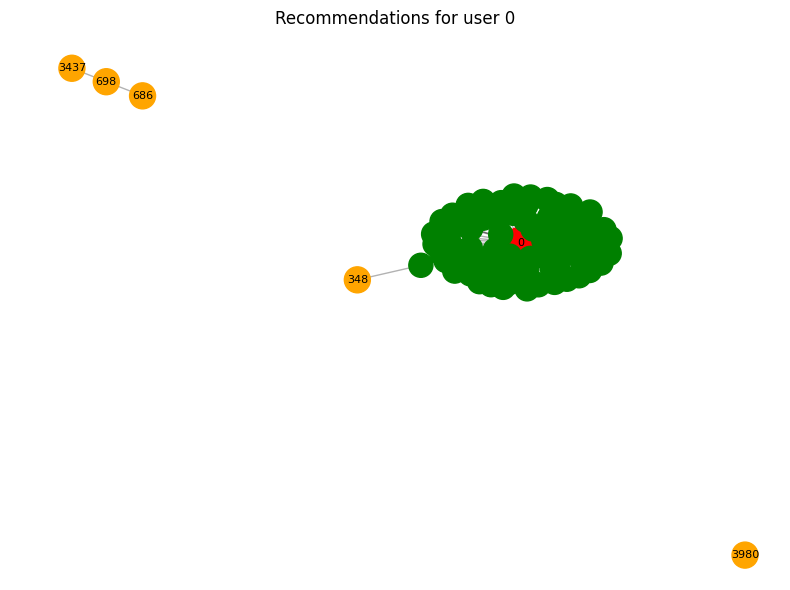

In [ ]:
def plot_user_recommendations(user_id, top_k=5):
    top_k = int(top_k)
    if user_id not in node_to_id:
        raise ValueError('user_id not found')

    u = node_to_id[user_id]
    friends = set(G.neighbors(u))
    recs = recommend_friends(user_id, top_k=top_k)
    rec_internal = [node_to_id[rid] for rid, _ in recs]

    nodes = {u} | friends | set(rec_internal)
    # Keep neighborhood plot readable in dense ego-graphs
    if len(nodes) > 120:
        nodes = {u} | set(list(friends)[:80]) | set(rec_internal)

    SG = G.subgraph(nodes).copy()
    pos = nx.spring_layout(SG, seed=SEED)

    colors = []
    sizes = []
    for n in SG.nodes():
        if n == u:
            colors.append('red')
            sizes.append(500)
        elif n in rec_internal:
            colors.append('orange')
            sizes.append(350)
        elif n in friends:
            colors.append('green')
            sizes.append(300)
        else:
            colors.append('lightgray')
            sizes.append(150)

    fig, ax = plt.subplots(figsize=(8, 6))
    nx.draw_networkx_edges(SG, pos, alpha=0.3, ax=ax)
    nx.draw_networkx_nodes(SG, pos, node_color=colors, node_size=sizes, ax=ax)

    labels = {u: str(id_to_node[u])}
    for n in rec_internal:
        if n in SG:
            labels[n] = str(id_to_node[n])
    nx.draw_networkx_labels(SG, pos, labels=labels, font_size=8, ax=ax)

    ax.set_title(f'Recommendations for user {user_id}')
    ax.axis('off')
    fig.tight_layout()
    return fig

fig = plot_user_recommendations(sample_user, top_k=5)
plt.show()


## 9) Interactive Interface (Gradio)

In [ ]:
# Restrict dropdown cardinality to keep Gradio rendering responsive
top_users_internal = np.argsort(-degree)[:1000]
top_users_original = [id_to_node[i] for i in top_users_internal]
choices = [str(u) for u in top_users_original]
choice_to_user = {str(u): u for u in top_users_original}

# Ensure previous Gradio sessions are closed before relaunch
gr.close_all()

def ui_recommend(user_str, top_k):
    # Slider values can arrive as float in some Gradio versions
    top_k = int(top_k)
    user_id = choice_to_user[str(user_str)]
    recs = recommend_friends(user_id, top_k=top_k)
    rec_df = pd.DataFrame(recs, columns=['recommended_user', 'score'])
    fig = plot_user_recommendations(user_id, top_k=top_k)
    return rec_df, fig

demo = gr.Interface(
    fn=ui_recommend,
    inputs=[
        gr.Dropdown(choices=choices, value=choices[0], label='Select user'),
        gr.Slider(minimum=1, maximum=20, value=5, step=1, label='Top-K')
    ],
    outputs=[
        gr.Dataframe(label='Recommendations'),
        gr.Plot(label='Graph')
    ],
    title='Mini Social Friend Recommender',
    description='Simple GCN link prediction demo on SNAP Facebook graph.'
)

def is_colab_runtime():
    try:
        import google.colab  # noqa: F401
        return True
    except Exception:
        return False

demo.queue()

if is_colab_runtime():
    try:
        # In Colab, share=True usually creates a reachable public URL
        demo.launch(share=True, debug=True)
    except Exception as e:
        print('share=True launch failed. Retrying without share. Error:', e)
        demo.launch(debug=True)
else:
    demo.launch(debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e5dd037b634567e8cb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e5dd037b634567e8cb.gradio.live
